In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants and parameters
R = 0.00008314  # Gas constant in (10^-5)J/mol-K 
REF_TEMP = 298.15  # Reference temperature in Kelvin
REF_PRESSURE = 1  # Reference pressure in bar
CRIT_TEMP = 405.6  # Critical temperature in Kelvin
CRIT_PRESS = 112.8  # Critical pressure in bar
CP_COEFF_A = 27.551
CP_COEFF_B = 0.02563
CP_COEFF_C = 0.0000099
CP_COEFF_D = -0.000000006687
ACENTRIC_FACTOR = 0.25  # Acentric factor for the fluid

# Solving cubic equation
def solve_cubic(A, B):
    coeffs = cubic_eq_coeffs(A, B)
    roots = np.roots(coeffs)
    roots_real = np.real(roots[np.isreal(roots)])
    return np.min(roots_real), np.max(roots_real)
    
    # Calculating Peng-Robinson constants
def calc_a(T):
    kappa = 0.37464 + 1.54226*ACENTRIC_FACTOR - 0.26992*ACENTRIC_FACTOR**2  # Peng-Robinson kappa
    return 0.45724 * R**2 * CRIT_TEMP**2 / CRIT_PRESS * (1 + kappa * (1 - np.sqrt(T/CRIT_TEMP)))**2

def calc_b():
    return 0.07780 * R * CRIT_TEMP / CRIT_PRESS

# Fugacity calculation function
def fugacity(Z, A, B, P):
    term1 = Z - 1
    term2 = np.log(Z - B)
    term3 = (A / (2 * np.sqrt(2) * B)) * np.log((Z + (1 + np.sqrt(2)) * B) / (Z + (1 - np.sqrt(2)) * B))
    return np.exp(term1 + term2 - term3)*P

# Cubic equation coefficients
def cubic_eq_coeffs(A, B):
    return [1, -(1 - B), A - 3*B**2 - 2*B, -(A*B - B**2 - B**3)]



# To calculate Vapor pressure 
def find_vapor_pressure(T):
    if T >= CRIT_TEMP:
        return None
    P_guess = 0.1
    step = 0.01
    divergence_detected = False

    while True:
        A = calc_a(T) * P_guess / (R * T)**2
        B = calc_b() * P_guess / (R * T)
        Z_liquid, Z_vapor = solve_cubic(A, B)

        f_liquid = fugacity(Z_liquid, A, B, P_guess)
        f_vapor = fugacity(Z_vapor, A, B, P_guess)

        if not divergence_detected:
            if abs(Z_liquid - Z_vapor) > 1e-5:
                divergence_detected = True 
        else:
            if abs(f_liquid - f_vapor) < 1e-10:
                return P_guess

        P_guess += step

# To calculate Integral terms for Cp 
def integral_Cp(T, REF_TEMP):
    term1 = CP_COEFF_A * (T - REF_TEMP)
    term2 = (CP_COEFF_B / 2) * (T**2 - REF_TEMP**2)
    term3 = (CP_COEFF_C / 3) * (T**3 - REF_TEMP**3)
    term4 = (CP_COEFF_D / 4) * (T**4 - REF_TEMP**4)
    return term1 + term2 + term3 + term4

def integral_Cp_over_T(T, REF_TEMP):
    term1 = CP_COEFF_A * np.log(T / REF_TEMP)
    term2 = CP_COEFF_B* (T - REF_TEMP)
    term3 = (CP_COEFF_C/ 2) * (T**2 - REF_TEMP**2)
    term4 = (CP_COEFF_D / 3) * (T**3 - REF_TEMP**3)
    return term1 + term2 + term3 + term4

# To calculate Properties 
def calculate_properties(T, P, vapor_pressure):
    A = calc_a(T) * P / (R * T)**2
    B = calc_b() * P / (R * T)
    Z_liquid, Z_vapor = solve_cubic(A, B)
    
    if T < CRIT_TEMP:
        Z = Z_liquid if P > vapor_pressure else Z_vapor
    else:
        Z = Z_vapor

    V = 1000 * Z * R * T / P
    da_dT = np.gradient([calc_a(T-1), calc_a(T), calc_a(T+1)])
    H_H_IG = R * T * (Z - 1) + (T * da_dT[1] - calc_a(T)) / (2 * calc_b() * np.sqrt(2)) * \
             np.log((Z + (1 + np.sqrt(2)) * B) / (Z + (1 - np.sqrt(2)) * B))
    
    H = ((H_H_IG) * 1e5 + integral_Cp(T, REF_TEMP)) / 1000

    S_S_IG = R * np.log(Z - B) + (da_dT[1] / (2 * calc_b() * np.sqrt(2))) * \
             np.log((Z + (1 + np.sqrt(2)) * B) / (Z + (1 - np.sqrt(2)) * B))
    
    S = (S_S_IG) * 1e5 + integral_Cp_over_T(T, REF_TEMP) - R * 1e5 * np.log(P)
    
    return Z, V, H, S
    

In [48]:
# Plotting functions
def plot_PV():
    temperature_list = [248.15, 273.15, 298.15, 305.4, 323.15, 348.15, 373.15, 398.15, 405.6, 423.15, 448.5, 473.15]
    pressure_values = np.linspace(1, 200, 200)  # Logarithmic scale requires wide, evenly spaced range

    plt.figure(figsize=(10, 6))
    for T in temperature_list:
        vapor_pressure = find_vapor_pressure(T)
        V_values = [calculate_properties(T, P, vapor_pressure)[1] for P in pressure_values]
        
        plt.plot(V_values, pressure_values, label=f'T = {T} K')

    # Set labels and scales
    plt.xlabel("V (m^3/kmol)")
    plt.ylabel("P (bar)")
    plt.yscale("log")  # Logarithmic scale for pressure
    plt.xscale("log")  # Logarithmic scale for volume
    
    # Set y-axis ticks and limits
    pressure_ticks = [1, 5, 10, 20, 30, 50, 70, 100, 120, 150, 170, 200]
    plt.yticks(pressure_ticks, pressure_ticks)
    plt.ylim(1, 200)

    # Set x-axis ticks and limits
    volume_ticks = np.logspace(-2, 1.6, 8)  # Logarithmic range for volume
    plt.xticks(volume_ticks, [f"{tick:.2f}" for tick in volume_ticks])
    plt.xlim(0.01, 12)

    # Add title, legend, and grid
    plt.title("P vs V for Various Temperatures")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Show the plot
    plt.show()


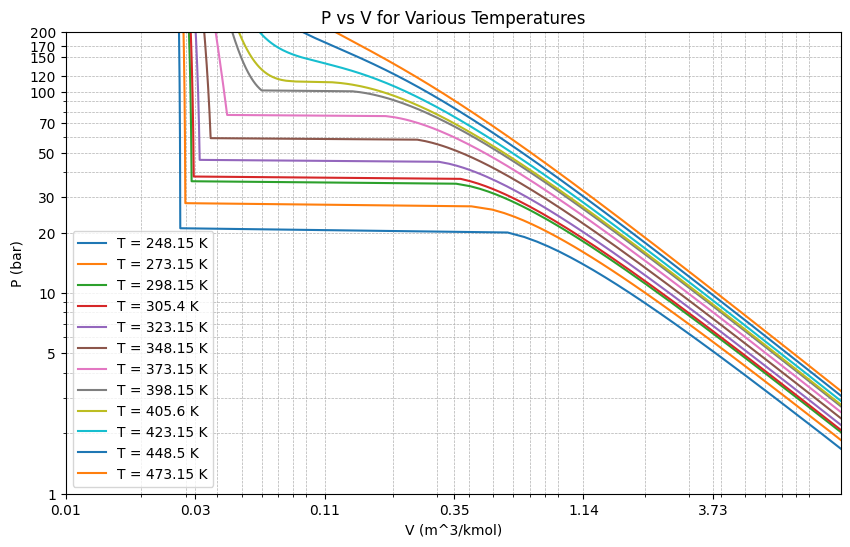

In [49]:
plot_PV()

In [25]:
def plot_PH():
    temperature_list = [223.15, 248.15, 273.15, 298.15,CRIT_TEMP, 323.15, 348.15, 373.15, 398.15, 423.15,448.515,473.15]
    pressure_values = np.linspace(1, 150, 150)

    plt.figure(figsize=(10, 6))
    for T in temperature_list:
        vapor_pressure = find_vapor_pressure(T)
        H_values = [calculate_properties(T, P, vapor_pressure)[2] for P in pressure_values]
        
        plt.plot(H_values, pressure_values, label=f'T = {T} K')

    plt.xlabel("H (kJ/mol)")
    plt.ylabel("P (bar)")
    plt.yticks([1, 5, 10, 20, 30, 50, 70, 100,120,150], [1, 5, 10, 20, 30, 50, 70, 100,120,150])
    plt.xticks([-30,-28,-26, -24, -22, -20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14], 
               [-30,-28,-26, -24, -22, -20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14])
    plt.title("P vs H for Various Temperatures")
    plt.legend(loc='upper right')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


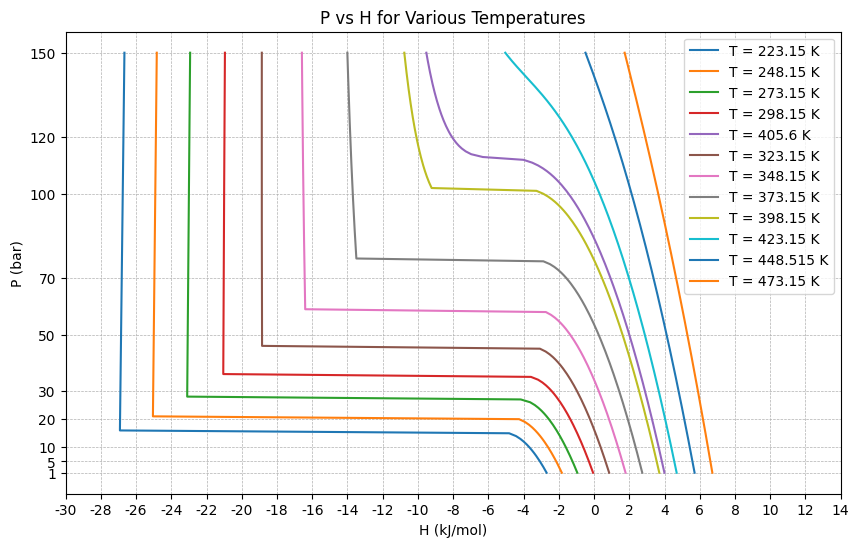

In [26]:
plot_PH()

In [50]:
def plot_TS_simple():
    pressure_list = [ 20, 30, 40, 50, 60, 70, 80, 90, 100, 112.8, 120, 135]
    temperature_values = np.linspace(123.15, 523.15, 100)

    # Precompute constants and vapor pressures for all temperatures
    vapor_pressures = {T: find_vapor_pressure(T) for T in temperature_values}
    a_values = {T: calc_a(T) for T in temperature_values}
    da_dT_values = {
        T: (calc_a(T + 1) - calc_a(T - 1)) / 2 for T in temperature_values
    }  # Central difference approximation
    b_value = calc_b()

    plt.figure(figsize=(10, 6))

    # Iterate over pressures
    for P in pressure_list:
        S_values = []
        for T in temperature_values:
            vapor_pressure = vapor_pressures[T]
            a = a_values[T]
            da_dT = da_dT_values[T]

            A = a * P / (R * T) ** 2
            B = b_value * P / (R * T)
            Z_liquid, Z_vapor = solve_cubic(A, B)
            Z = Z_liquid if T < CRIT_TEMP and P > vapor_pressure else Z_vapor

            # Calculate entropy (S)
            S_S_IG = (
                R * np.log(Z - B)
                + (da_dT / (2 * b_value * root2))
                * np.log((Z + (1 + root2) * B) / (Z + (1 - root2) * B))
            )
            S = (S_S_IG * 1e5 + integral_Cp_over_T(T, REF_TEMP) - R * 1e5 * np.log(P))
            S_values.append(S)

        # Plot S vs T for this pressure
        plt.plot(S_values, temperature_values, label=f'P = {P} bar')

    plt.xlabel("S (J/molK)")
    plt.ylabel("T (K)")
    plt.xticks([-120, -100, -80, -60, -40, -20, 0, 20, 40], 
               [-120, -100, -80, -60, -40, -20, 0, 20, 40])
    plt.title("T vs S for Various Pressures")
    plt.legend(loc='upper right')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


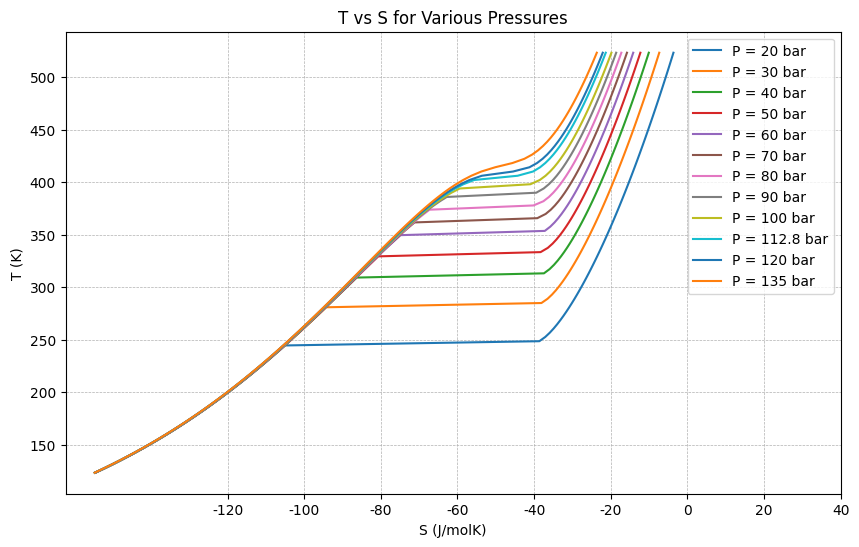

In [51]:
plot_TS_simple()